In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.decomposition import PCA

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, Perceptron
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, RandomizedSearchCV, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler,MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_classif, chi2, SelectPercentile
from sklearn.feature_extraction import FeatureHasher
import datetime as dt


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC, OneClassSVM
from sklearn import tree
from sklearn.tree import export_text

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

In [3]:
#loading train and test datasets
train = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
test  = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")

In [4]:
#splitting the training dataset into feature and target matrices
train.head()
X = train.drop('Crime_Category', axis = 1)
y = train[['Crime_Category']]

X_test = test

In [5]:
'''from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

from sklearn.dummy import DummyClassifier

model = DummyClassifier()
model.fit(X_train, y_train)
model.predict(X_val)'''

'from sklearn.model_selection import train_test_split\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)\n\nfrom sklearn.dummy import DummyClassifier\n\nmodel = DummyClassifier()\nmodel.fit(X_train, y_train)\nmodel.predict(X_val)'

In [6]:
'''y_pred = model.predict(X_test)'''

'y_pred = model.predict(X_test)'

In [7]:
'''submission = pd.DataFrame({"ID": np.arange(1,5001), 
                           "Crime_Category": y_pred,
                          }
                         ) 

submission.to_csv('submission.csv',index=False)'''

'submission = pd.DataFrame({"ID": np.arange(1,5001), \n                           "Crime_Category": y_pred,\n                          }\n                         ) \n\nsubmission.to_csv(\'submission.csv\',index=False)'

# **Exploratory Data Analysis**

## Columns Description:

1. Location: Street address of the crime incident.
2. Cross_Street: Cross street of the rounded address.
3. Latitude: Latitude coordinates of the crime incident.
4. Longitude: Longitude coordinates of the crime incident.
5. Date_Reported: Date the incident was reported.
6. Date_Occurred: Date the incident occurred.
7. Time_Occurred: Time the incident occurred in 24-hour military time.
8. Area_ID: LAPD's Geographic Area number.
9. Area_Name: Name designation of the LAPD Geographic Area.
10. Reporting_District_no: Reporting district number.
11. Part 1-2: Crime classification.
12. Modus_Operandi: Activities associated with the suspect.
13. Victim_Age: Age of the victim.
14. Victim_Sex: Gender of the victim.
15. Victim_Descent: Descent code of the victim.
16. Premise_Code: Premise code indicating the location of the crime.
17. Premise_Description: Description of the premise code.
18. Weapon_Used_Code: Weapon code indicating the type of weapon used.
19. Weapon_Description: Description of the weapon code.
20. Status: Status of the case.
21. Status_Description: Description of the status code.
22. Crime_Category: The category of the crime (Target Variable)

In [8]:
'''getting high level idea about the nulls and unique values of the columns'''

for col in X.columns:
    print(f'Column Name : {col} \nUnique Values : {len(X[col].unique())} \nNulls : {X[col].isna().sum()}\n---------------------')

Column Name : Location 
Unique Values : 12399 
Nulls : 0
---------------------
Column Name : Cross_Street 
Unique Values : 1496 
Nulls : 16552
---------------------
Column Name : Latitude 
Unique Values : 3622 
Nulls : 0
---------------------
Column Name : Longitude 
Unique Values : 3578 
Nulls : 0
---------------------
Column Name : Date_Reported 
Unique Values : 811 
Nulls : 0
---------------------
Column Name : Date_Occurred 
Unique Values : 366 
Nulls : 0
---------------------
Column Name : Time_Occurred 
Unique Values : 996 
Nulls : 0
---------------------
Column Name : Area_ID 
Unique Values : 21 
Nulls : 0
---------------------
Column Name : Area_Name 
Unique Values : 21 
Nulls : 0
---------------------
Column Name : Reporting_District_no 
Unique Values : 1120 
Nulls : 0
---------------------
Column Name : Part 1-2 
Unique Values : 2 
Nulls : 0
---------------------
Column Name : Modus_Operandi 
Unique Values : 10490 
Nulls : 2741
---------------------
Column Name : Victim_Age 


In [9]:
#checking the unique values and their counts 
train['Modus_Operandi'].value_counts()

Modus_Operandi
0344                                       826
0329                                       583
1501                                       187
0329 1300                                  135
0325                                       127
                                          ... 
1609 0329 1307 0344                          1
0344 2050 0910 2034                          1
0400 2000 0913                               1
1822 0342 0910 2049 2051 0305 0444 0344      1
1202 2038 0913 0602 1242 0553                1
Name: count, Length: 10489, dtype: int64

In [10]:
#checking the unique crime categories and their counts
train['Crime_Category'].value_counts()

Crime_Category
Property Crimes                  11666
Violent Crimes                    4767
Crimes against Public Order       1808
Fraud and White-Collar Crimes     1355
Crimes against Persons             225
Other Crimes                       179
Name: count, dtype: int64

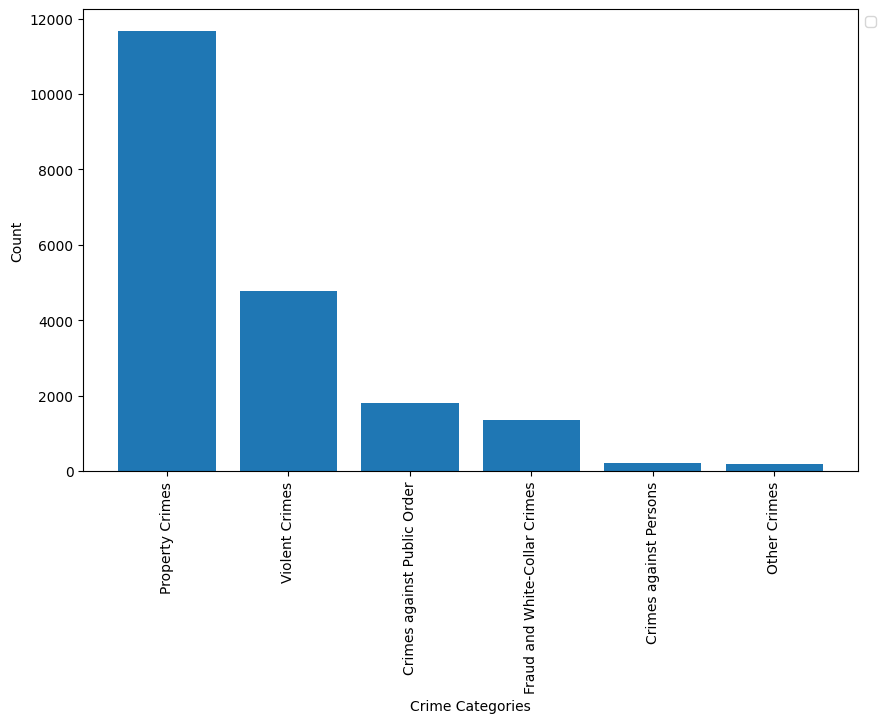

In [11]:
#plotting bar chart of target variable for visualisation of classes
plt.figure(figsize = (10,6))
crime_category = train['Crime_Category'].value_counts()
plt.bar(crime_category.index,crime_category.values)
plt.legend(bbox_to_anchor = (1,1), loc = "upper left")
plt.xticks(rotation = 90)
plt.xlabel("Crime Categories")
plt.ylabel("Count")
plt.show()

Majority Class:

The majority class is "Property Crimes" with 11,666 instances, constituting a large portion of the dataset.

This class imbalance can cause the model to be biased towards predicting "Property Crimes" more often because it is the most frequent class.

Minority Classes:

The minority classes are "Crimes against Persons" and "Other Crimes" with only 225 and 179 instances, respectively.

These classes are underrepresented, which means the model may not learn enough about these categories to make accurate predictions.

In [12]:
#checking incorrect values within victim's age and their counts
train[(train['Victim_Age'] < 0)][['Victim_Age','Victim_Sex','Crime_Category']].value_counts()

Victim_Age  Victim_Sex  Crime_Category               
-1.0        X           Property Crimes                  2
-2.0        M           Fraud and White-Collar Crimes    1
            X           Property Crimes                  1
-1.0        F           Property Crimes                  1
            M           Property Crimes                  1
Name: count, dtype: int64

We can clearly see that there are certain values within the column 'Victime_Age' that are marked incorrectly. Since age cannot be less than zero, these values will be converted to np.nan and then imputed later within the preprocessing and ml model pipeline.

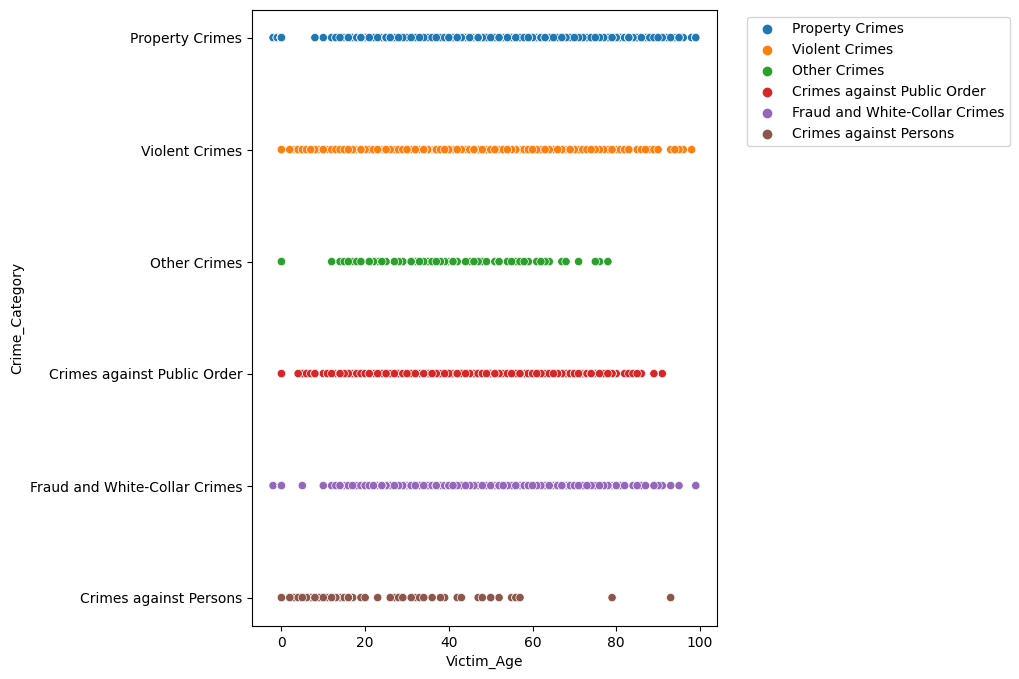

In [13]:
#plotting a scatterplot graph between victim's age and crime category to see
#if there's a pattern seen across the victim's age group
plt.figure(figsize = (6,8))
sns.scatterplot(data = train, x = 'Victim_Age', y = 'Crime_Category', hue = 'Crime_Category')
plt.legend(bbox_to_anchor=(1.05, 1))

1. Both property and violent crimes have victims across all age groups, indicating their pervasive nature.

2. Crimes against public order, fraud, white-collar crimes, and other crimes primarily impact adults in **their middle ages**, highlighting a specific vulnerability in this age group.

3. Crimes against persons and other crimes have fewer instances, suggesting these are less common.

4. The data shows that certain crimes like fraud and white-collar crimes are more likely to impact financially active adults.


In [14]:
#checking unique values and their counts
train['Victim_Sex'].value_counts()

Victim_Sex
M    8538
F    7176
X    1660
H       2
Name: count, dtype: int64

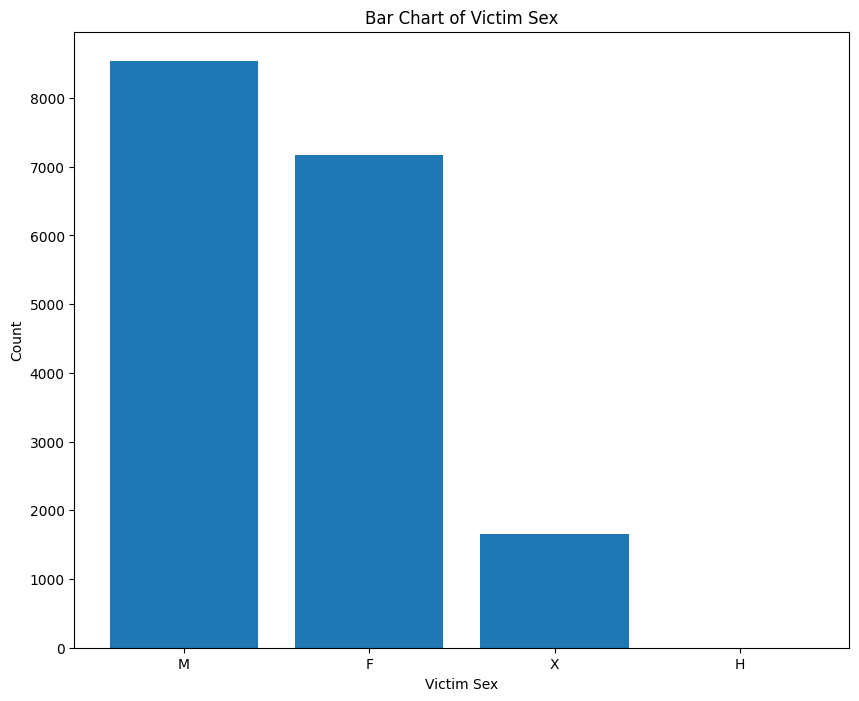

In [15]:
victim_sex = train['Victim_Sex'].value_counts()

# plotting bar chart for victim sex
plt.figure(figsize=(10, 8))
plt.bar(victim_sex.index, victim_sex.values)
plt.title('Bar Chart of Victim Sex')
plt.xlabel('Victim Sex')
plt.ylabel('Count')
plt.show()

1. The largest number of crime victims are males, exceeding 9,000.

2. This indicates that males are the most frequent victims of crimes in the dataset.

3. Females are the second most frequent victims, with a count of over 7,000.

4. Although fewer than males, a significant number of females are also victims of crimes.

6. The count for victims categorized as Other is significantly lower, with fewer than 2,000 instances. This category most probably includes non-binary, genderqueer, or other gender identities which do not fall into the male or female categories.

6. Another category named "H" is unknown. It has only 2 values.


In [16]:
train.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


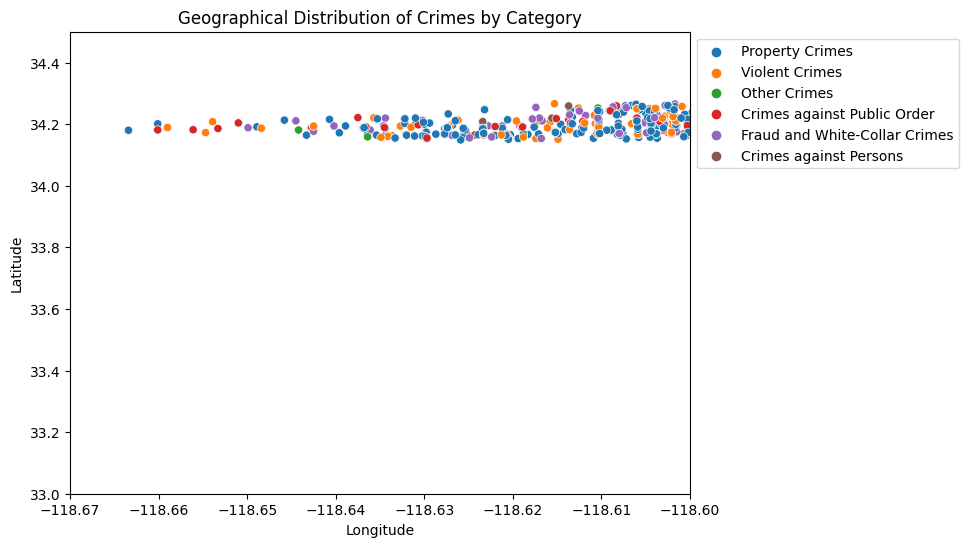

In [17]:
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(data=train, x='Longitude', y='Latitude', hue='Crime_Category', palette='tab10')

#plotting scatter plot for identifying a potential relationship between Crime
#and geographical location
plt.xlim(-118.67, -118.60)
plt.ylim(33, 34.5) 

plt.title('Geographical Distribution of Crimes by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

We can see that most crime categories are evenly spread across the geographical area, suggesting that crime is not confined to specific locations but rather widespread.

There are no obvious hotspots where any particular crime category is highly concentrated. This shows that the crimes are fairly dispersed.

The fact that the majority of crime categories are equally dispersed throughout the region indicates that crime is not limited to any particular region but rather occurs all over the place.

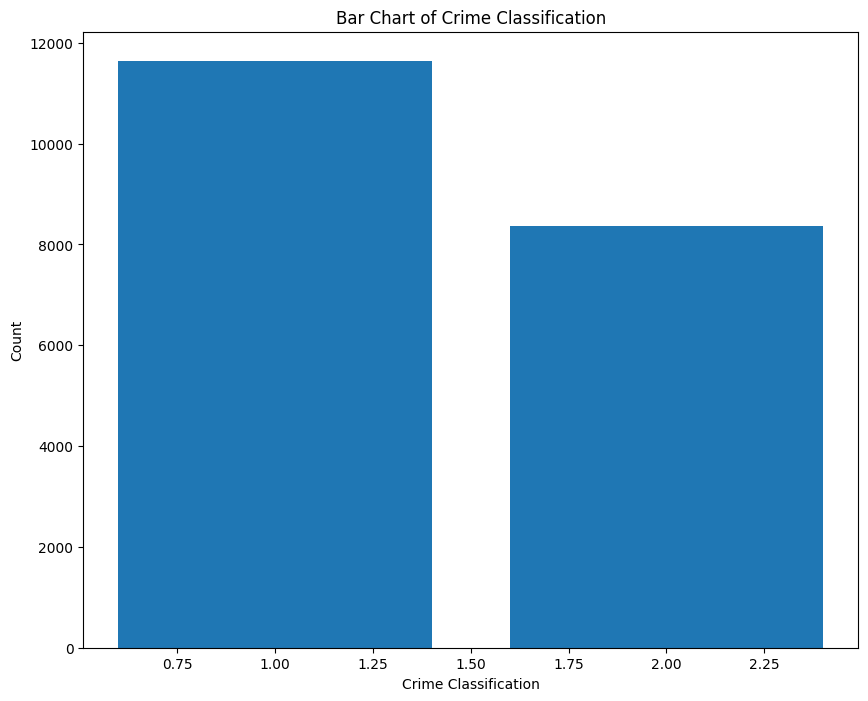

In [18]:
crime_clf = train['Part 1-2'].value_counts()

#plotting bar chart for crime classification column
plt.figure(figsize=(10, 8))
plt.bar(crime_clf.index, crime_clf.values)
plt.title('Bar Chart of Crime Classification')
plt.xlabel('Crime Classification')
plt.ylabel('Count')
plt.show()

The graph clearly shows that the crime classification for part 1 is greater than part 2. 
For Part 1, the count is 11000+, however, for Part 2, the count is little less than 9000.

In [19]:
train['Status_Description'].value_counts()

Status_Description
Invest Cont     15236
Adult Other      2597
Adult Arrest     2054
Juv Arrest         70
Juv Other          43
Name: count, dtype: int64

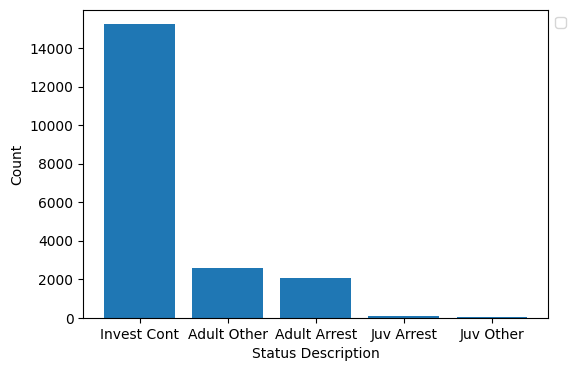

In [20]:
status_desc = train['Status_Description'].value_counts()

#plotting bar chart for status description
plt.figure(figsize = (6,4))
plt.bar(status_desc.index, status_desc.values)
plt.xlabel("Status Description")
plt.ylabel("Count")
plt.legend(bbox_to_anchor = (1,1), loc = "upper left")
plt.show()

A huge majority of cases are still under investigation, indicating a lengthy process of investigations or several backlogs in resolving cases.
There is a considerable number of adult cases that have resulted in either arrest or other outcomes.
Both juvenile arrest and other outcomes have very low counts, having a positive point to show that juveniles are involved in a considerably small number of cases.

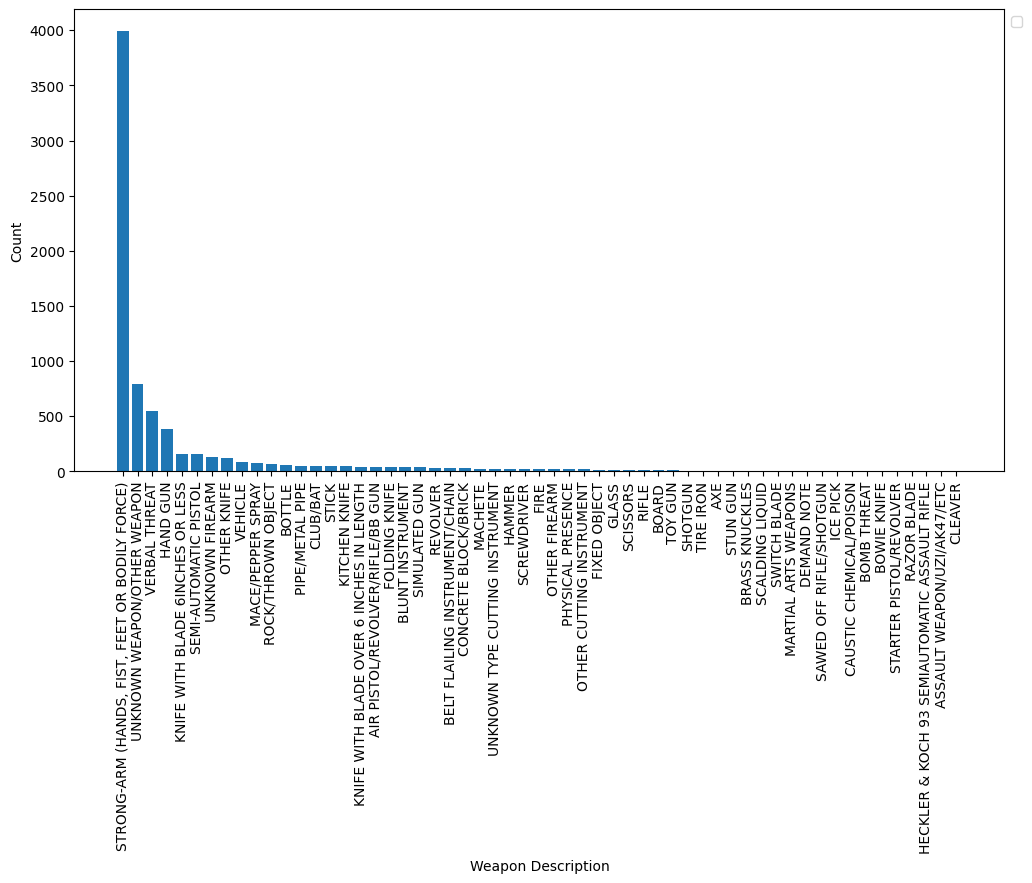

In [21]:
weapon_desc = train['Weapon_Description'].value_counts()

#plotting bas chart for weapon description
plt.figure(figsize = (12,6))
plt.bar(weapon_desc.index, weapon_desc.values)
plt.xlabel("Weapon Description")
plt.ylabel("Count")
plt.legend(bbox_to_anchor = (1,1), loc = "upper left")
plt.xticks(rotation = 90)
plt.show()

Here, we can see that "Strong-Arm (Hands, Fist, Feet, or bodily Force)" are the weapons that are extremely highly used for attacking.
Other methods like verbal threats and hand-guns are used seldom.
However, other miscellaneuos weapons are used in neglible amount.

# Model Building

## Pre-Processing Data

In [22]:
X = train.drop('Crime_Category', axis = 1)
y = train[['Crime_Category']]

############################ cleaning the columns ###########################

import re
# training data
X['Location'] = X['Location'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))
X['Cross_Street'] = X['Cross_Street'].apply(lambda x: re.sub(r'\s+', ' ', str(x).strip()))
X['Reporting_District_no'] = X['Reporting_District_no'].astype(int)
X['Part 1-2'] = X['Part 1-2'].astype(int)
X['Area_ID'] = X['Area_ID'].astype(int)
X['Modus_Operandi'] = X['Modus_Operandi'].astype(str)
X['Premise_Code'] = X['Premise_Code'].astype(int)
X['Victim_Age'].replace({-1 : np.nan, -2 : np.nan}, inplace = True)

## testing data
X_test['Location'] = X_test['Location'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))
X_test['Reporting_District_no'] = X_test['Reporting_District_no'].astype(int)
X_test['Part 1-2'] = X_test['Part 1-2'].astype(int)
X_test['Area_ID'] = X_test['Area_ID'].astype(int)
X_test['Modus_Operandi'] = X_test['Modus_Operandi'].astype(str)
X_test['Premise_Code'] = X_test['Premise_Code'].astype(int)
X_test['Victim_Age'].replace({-1 : np.nan, -2 : np.nan}, inplace = True)

/tmp/ipykernel_18/4264154121.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Victim_Age'].replace({-1 : np.nan, -2 : np.nan}, inplace = True)
/tmp/ipykernel_18/4264154121.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [23]:
# encoding y variables
lb = LabelEncoder()
y_encoded = lb.fit_transform(y)

#splitting train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size = 0.20, random_state = 42)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
'''developing pipeline for preprocessing of the columns'''

#basic categorical variables preprocessing- One Hot Encoding
cat_pipe = Pipeline([
    ("cat_imputer", SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist'))
])

#text vectorizer pipeline 
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer())
])

#basic numerical variables preprocessing
num_pipe = Pipeline([
    ("num_imputer", SimpleImputer(strategy='mean')),
    ("poly", PolynomialFeatures(degree = 3, interaction_only = True)),
    ("ss", StandardScaler())
])

#basic categorical variables preprocessing- Ordinal Encoding
ordinal_pipe = Pipeline([
    ("cat_imputer", SimpleImputer(strategy='most_frequent')),
    ('oe', OrdinalEncoder(handle_unknown = "use_encoded_value", encoded_missing_value = 0, unknown_value = -2))
])

#combining the pipelines in Column Transformers
preprocess = ColumnTransformer([
    ("cat", cat_pipe,['Premise_Description','Weapon_Used_Code', \
                      'Weapon_Description']),
    
    ("num", num_pipe,['Latitude', 'Longitude','Reporting_District_no',\
                      'Area_ID','Premise_Code']),
    
    ("ordinal_encode", ordinal_pipe,['Victim_Sex','Status','Part 1-2','Victim_Age',\
                                     'Victim_Descent','Area_Name','Status_Description']),
    
    ('vectorizer',text_pipe,'Modus_Operandi')
], remainder = "drop")

## Logistic Regression (Baseline Model)

In [25]:
# running baseline model- Logistic Regression
log_reg = LogisticRegression(multi_class= "multinomial", max_iter = 100000, solver = 'newton-cg')
pipeline_lr = Pipeline([
    ("preprocess", preprocess),
    ("estimator", log_reg)
])

pipeline_lr.fit(X_train, y_train)
predictions = pipeline_lr.predict(X_val)

#predicting with validation test
acc_lr = accuracy_score(y_val, predictions)
pre_lr = precision_score(y_val, predictions, average = 'weighted')
rec_lr = recall_score(y_val, predictions, average = 'weighted')
list_lr = [acc_lr,pre_lr,rec_lr] #list for plotting
accuracy_score(y_val, predictions)

0.9485

In [26]:
#generating classification report for model evaluation
print("Logistic Regression Report:\n", classification_report(y_val, predictions))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.62      0.50      0.55        32
           1       0.85      0.83      0.84       374
           2       0.95      0.94      0.95       267
           3       0.73      0.31      0.44        35
           4       0.98      0.98      0.98      2303
           5       0.91      0.95      0.93       989

    accuracy                           0.95      4000
   macro avg       0.84      0.75      0.78      4000
weighted avg       0.95      0.95      0.95      4000



## SVC Model

In [27]:
#running SVC model
linear_svm = SVC(kernel='linear',decision_function_shape = "ovr",break_ties = True)

pipeline_svm = Pipeline([
    ("preprocess", preprocess),
    ("estimator", linear_svm)
])

pipeline_svm.fit(X_train, y_train)
predictions = pipeline_svm.predict(X_val)

#predicting with validation test
acc_svc = accuracy_score(y_val, predictions)
pre_svc = precision_score(y_val, predictions, average = 'weighted')
rec_svc = recall_score(y_val, predictions, average = 'weighted')
list_svc = [acc_svc, pre_svc, rec_svc] #list for plotting
accuracy_score(y_val, predictions)

0.94625

In [28]:
print("SVC Report:\n", classification_report(y_val, predictions))

SVC Report:
               precision    recall  f1-score   support

           0       0.56      0.47      0.51        32
           1       0.82      0.82      0.82       374
           2       0.93      0.93      0.93       267
           3       0.48      0.29      0.36        35
           4       0.99      0.98      0.99      2303
           5       0.92      0.95      0.94       989

    accuracy                           0.95      4000
   macro avg       0.78      0.74      0.76      4000
weighted avg       0.94      0.95      0.94      4000



## XGBoost Classifier

In [29]:
#running XGBoost Classifier
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, grow_policy = 'depthwise')

pipeline_xgb = Pipeline([
    ("preprocess", preprocess),
    ("estimator", xgb_clf)
])

pipeline_xgb.fit(X_train, y_train)
predictions = pipeline_xgb.predict(X_val)

# Evaluate the model
#predicting with validation test
acc_xgb = accuracy_score(y_val, predictions)
pre_xgb = precision_score(y_val, predictions, average = 'weighted')
rec_xgb = recall_score(y_val, predictions, average = 'weighted')
list_xgb = [acc_xgb, pre_xgb, rec_xgb] #list for plotting
print("XGBoost Accuracy:", accuracy_score(y_val, predictions))

XGBoost Accuracy: 0.9555


In [30]:
#generating classification report for model evaluation
print("XGBoost Report:\n", classification_report(y_val, predictions))

XGBoost Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69        32
           1       0.85      0.85      0.85       374
           2       0.95      0.93      0.94       267
           3       0.30      0.09      0.13        35
           4       0.99      0.99      0.99      2303
           5       0.94      0.96      0.95       989

    accuracy                           0.96      4000
   macro avg       0.78      0.75      0.76      4000
weighted avg       0.95      0.96      0.95      4000



## Lightgbm Classifier

In [31]:
#running lightgbm classifier
lightgbm = LGBMClassifier(n_estimators=500, learning_rate=0.1)

pipeline_lgbm = Pipeline([
    ("preprocess", preprocess),
    ("estimator", lightgbm)
])

pipeline_lgbm.fit(X_train, y_train)
predictions = pipeline_lgbm.predict(X_val)

# Evaluate the model
#predicting with validation test
acc_gbm = accuracy_score(y_val, predictions)
pre_gbm = precision_score(y_val, predictions, average = 'weighted')
rec_gbm = recall_score(y_val, predictions, average = 'weighted')
list_gbm = [acc_gbm, pre_gbm, rec_gbm] #list for plotting
print("LighGBM Accuracy:", accuracy_score(y_val, predictions))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16551
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 304
[LightGBM] [Info] Start training from score -4.417654
[LightGBM] [Info] Start training from score -2.412121
[LightGBM] [Info] Start training from score -2.688248
[LightGBM] [Info] Start training from score -4.710531
[LightGBM] [Info] Start training from score -0.535823
[LightGBM] [Info] Start training from score -1.443394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [32]:
print("LighGBM Report:\n", classification_report(y_val, predictions))

LighGBM Report:
               precision    recall  f1-score   support

           0       0.69      0.62      0.66        32
           1       0.82      0.87      0.84       374
           2       0.96      0.93      0.94       267
           3       0.44      0.20      0.27        35
           4       0.99      0.99      0.99      2303
           5       0.94      0.95      0.94       989

    accuracy                           0.95      4000
   macro avg       0.81      0.76      0.77      4000
weighted avg       0.95      0.95      0.95      4000



In [33]:
'''# Parameter grid
param_grid = {
    'estimator__objective': ['gdbt','dart','goss']
}

# Grid Search
grid_search_gbm = GridSearchCV(pipeline_lgbm, 
                               param_grid, 
                               cv=3, 
                               scoring='accuracy', 
                               n_jobs=-1, 
                               error_score='raise',
                               refit = True,
                               return_train_score = True)
grid_search_gbm.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search_gbm.best_params_)

# Evaluate the model
print("LighGBM Accuracy:", accuracy_score(y_val, predictions))'''

'# Parameter grid\nparam_grid = {\n    \'estimator__objective\': [\'gdbt\',\'dart\',\'goss\']\n}\n\n# Grid Search\ngrid_search_gbm = GridSearchCV(pipeline_lgbm, \n                               param_grid, \n                               cv=3, \n                               scoring=\'accuracy\', \n                               n_jobs=-1, \n                               error_score=\'raise\',\n                               refit = True,\n                               return_train_score = True)\ngrid_search_gbm.fit(X_train, y_train)\n\n# Best parameters\nprint("Best parameters found: ", grid_search_gbm.best_params_)\n\n# Evaluate the model\nprint("LighGBM Accuracy:", accuracy_score(y_val, predictions))'

## Model Comparison

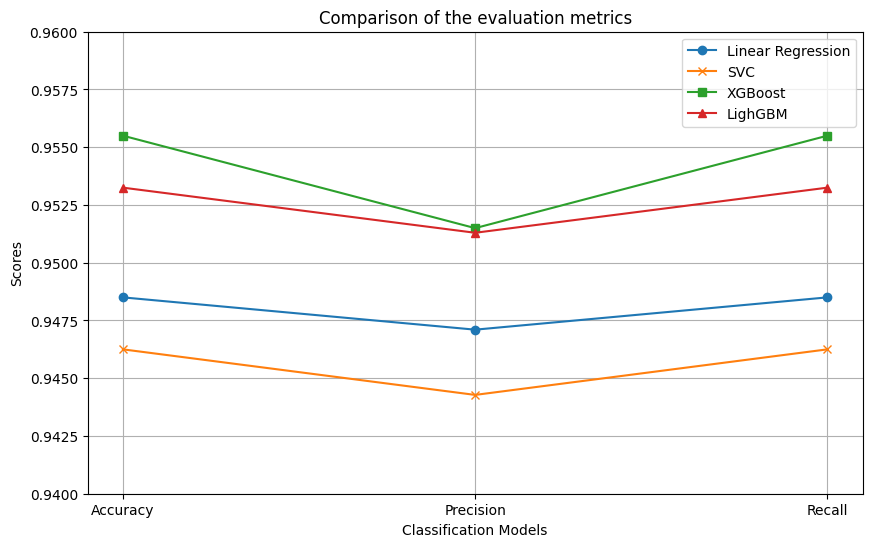

In [34]:
x = range(len(list_lr))
x_labels = ['Accuracy', 'Precision', 'Recall']

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(x, list_lr, label='Linear Regression', marker='o')
plt.plot(x, list_svc, label='SVC', marker='x')
plt.plot(x, list_xgb, label='XGBoost', marker='s')
plt.plot(x, list_gbm, label='LighGBM', marker='^')

# Adding title and labels
plt.title('Comparison of the evaluation metrics')
plt.xlabel('Classification Models')
plt.ylabel('Scores')
plt.xticks(x, x_labels)

# Adding limits
plt.ylim(0.94,0.96)
# Adding a legend
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

Interpretation and Comparison:

1. XGBoost outperforms on the validation dataset than other models across all three metrics—accuracy, precision, and recall showing the most balanced performance, thus, making it a robust choice for classification tasks in this context.

2. LightGBM is the second-best performer on the validation set, closely following XGBoost in all metrics. It also shows balanced performance, slightly lower than XGBoost but still superior to the other two models.

3. Logistic Regression and SVC lag behind XGBoost and LightGBM. Both models show lower scores in all metrics, with SVC having the lowest precision and recall among the four models.

4. This indicates that XGBoost and LightGBM are more effective in handling the dataset and the classification task due to their advanced boosting techniques that help in better generalization and handling complex patterns in data.

In the case of test set, however, the accuracy score of LighGBM model outperforms the XGBoost! This could be due to a higher ability to handle complex datasets and handling large-scale data and high-dimensional features more effectively.


In [35]:
y_pred = pipeline_lgbm.predict(X_test)
y_pred = lb.inverse_transform(y_pred)

# Submission

In [36]:
submission = pd.DataFrame({"ID": np.arange(1,5001), 
                           "Crime_Category": y_pred,
                          }
                         ) 

submission.to_csv('submission.csv',index=False)